In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import numpy as np
from skimage.color import rgb2lab

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models.feature_extraction import create_feature_extractor
from torchvision import models
from skimage import color

In [3]:
from torch.utils.data import Dataset, DataLoader
# Custom Dataset class for CIFAR-10
class ColorizationDataset(Dataset):
    def __init__(self, image_list):
        self.image_list = image_list
        self.transform = transforms.Compose([
            transforms.ToPILImage(),              # Ensure images are in PIL format
            transforms.Resize((224, 224)),        # Resize to 224x224
            transforms.ToTensor()                 # Convert to Tensor
        ])

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img = self.image_list[idx]

        # Apply the transformation
        img = self.transform(img)

        # Convert the resized RGB image to Lab color space
        img_lab = color.rgb2lab(np.array(img).transpose(1, 2, 0)).astype(np.float32)

        # Normalize the Lab channels
        img_lab = (img_lab / 100.0)  # Normalize L, a, b to [-1, 1]
        L = img_lab[:, :, 0:1]  # Input: L channel
        ab = img_lab[:, :, 1:]  # Target: ab channels

        # Convert to PyTorch tensor
        L = torch.from_numpy(L).permute(2, 0, 1)  # HxWx1 -> 1xHxW
        ab = torch.from_numpy(ab).permute(2, 0, 1)  # HxWx2 -> 2xHxW

        return L, ab


In [4]:
from torchvision.datasets import CIFAR10

# Function to load and preprocess CIFAR-10 dataset
def load_cifar10_data(batch_size):
    # Load CIFAR-10 dataset
    train_set = CIFAR10(root='./data', train=True, download=True, transform=None)
    test_set = CIFAR10(root='./data', train=False, download=True, transform=None)

    # Create custom ColorizationDataset
    train_data = ColorizationDataset([np.array(img) for img, _ in train_set])
    test_data = ColorizationDataset([np.array(img) for img, _ in test_set])

    # Create DataLoaders
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader


In [5]:

# Fusion block to combine features from ResNet and DenseNet
class FusionBlock(nn.Module):
    def __init__(self, in_channels_1, in_channels_2):
        super(FusionBlock, self).__init__()
        # 1x1 convolution to unify the channel size to 256 for both feature maps
        self.conv1 = nn.Conv2d(in_channels_1, 256, kernel_size=1)
        self.conv2 = nn.Conv2d(in_channels_2, 256, kernel_size=1)
        # Another 1x1 convolution to reduce the concatenated output back to 256 channels
        self.reduce_channels = nn.Conv2d(512, 256, kernel_size=1)

    def forward(self, x1, x2):
        # print(f'FusionBlock - Input x1 shape: {x1.shape}, Input x2 shape: {x2.shape}')
        x1 = self.conv1(x1)
        x2 = self.conv2(x2)
        # Concatenate the two feature maps along the channel dimension
        x = torch.cat([x1, x2], dim=1)
        # print(f'FusionBlock - After concat shape: {x.shape}')
        # Reduce the concatenated output back to 256 channels
        x = self.reduce_channels(x)
        # print(f'FusionBlock - After reducing channels shape: {x.shape}')
        return x

# Decoder block with upsampling and unified output to 256 channels
class DecoderBlock(nn.Module):
    def __init__(self, in_channels=256, out_channels=256):
        super(DecoderBlock, self).__init__()
        # Expecting 512 channels from the concatenated feature maps, reducing to 256
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)

    def forward(self, x, skip=None):
        # print(f'DecoderBlock - Input x shape: {x.shape}')
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        # print(f'DecoderBlock - After conv shape: {x.shape}')
        x = self.upsample(x)
        # print(f'DecoderBlock - After upsample shape: {x.shape}')

        if skip is not None:
            # print(f'DecoderBlock - Skip connection shape: {skip.shape}')
            # Upsample skip connection if needed to match spatial size
            if skip.shape[2:] != x.shape[2:]:
                skip = F.interpolate(skip, size=x.shape[2:], mode='bilinear', align_corners=False)
                # print(f'DecoderBlock - After skip upsample shape: {skip.shape}')
            x = x + skip
            # print(f'DecoderBlock - After adding skip shape: {x.shape}')

        return x

In [6]:

# Colorization Model using ResNet50 and DenseNet121
class ColorizationModel(nn.Module):
    def __init__(self):
        super(ColorizationModel, self).__init__()

        # Pretrained ResNet50 and DenseNet121 as encoders
        self.resnet = models.resnet50(pretrained=True)
        self.densenet = models.densenet121(pretrained=True)

        # Define the layers from which you want to extract features
        return_nodes_resnet = {
            'layer1': 'resnet_feats_56',   # Feature map size 56x56
            'layer2': 'resnet_feats_28',   # Feature map size 28x28
            'layer3': 'resnet_feats_14',   # Feature map size 14x14
            'layer4': 'resnet_feats_7'     # Feature map size 7x7
        }

        return_nodes_densenet = {
            'features.denseblock1': 'densenet_feats_56',   # Feature map size 56x56
            'features.denseblock2': 'densenet_feats_28',   # Feature map size 28x28
            'features.denseblock3': 'densenet_feats_14',   # Feature map size 14x14
            'features.denseblock4': 'densenet_feats_7'     # Feature map size 7x7
        }

        # Create feature extractors
        self.resnet_extractor = create_feature_extractor(self.resnet, return_nodes=return_nodes_resnet)
        self.densenet_extractor = create_feature_extractor(self.densenet, return_nodes=return_nodes_densenet)

        # Fusion blocks for multi-level features (each output after concatenation is 512 channels)
        self.fusion_56 = FusionBlock(256, 256)  # Concatenate to get 512 channels
        self.fusion_28 = FusionBlock(512, 512)  # Concatenate to get 512 channels
        self.fusion_14 = FusionBlock(1024, 1024)  # Concatenate to get 512 channels
        self.fusion_7 = FusionBlock(2048, 1024)  # Concatenate to get 512 channels

        # Decoder blocks with upsampling
        self.decoder_7 = DecoderBlock(256)   # Input 512 from fusion_7
        self.decoder_14 = DecoderBlock(256)  # Input 512 from fusion_14
        self.decoder_28 = DecoderBlock(256)  # Input 512 from fusion_28
        self.decoder_56 = DecoderBlock(256)  # Input 512 from fusion_56

        # Final output layer (predict ab channels)
        self.final_conv = nn.Conv2d(256, 2, kernel_size=3, padding=1)
        self.upsample_final = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)

    def forward(self, x):
        # Replicate grayscale input to 3 channels for ResNet and DenseNet
        x_rgb = x.repeat(1, 3, 1, 1)
        # print(f'Forward Pass - Initial input shape: {x_rgb.shape}')

        # Extract features from different stages of ResNet and DenseNet
        resnet_feats = self.resnet_extractor(x_rgb)
        densenet_feats = self.densenet_extractor(x_rgb)

        # Get features for each level
        resnet_feats_56 = resnet_feats['resnet_feats_56']
        resnet_feats_28 = resnet_feats['resnet_feats_28']
        resnet_feats_14 = resnet_feats['resnet_feats_14']
        resnet_feats_7 = resnet_feats['resnet_feats_7']

        densenet_feats_56 = densenet_feats['densenet_feats_56']
        densenet_feats_28 = densenet_feats['densenet_feats_28']
        densenet_feats_14 = densenet_feats['densenet_feats_14']
        densenet_feats_7 = densenet_feats['densenet_feats_7']

        # Fusion of multi-level features
        fusion_56 = self.fusion_56(resnet_feats_56, densenet_feats_56)
        fusion_28 = self.fusion_28(resnet_feats_28, densenet_feats_28)
        fusion_14 = self.fusion_14(resnet_feats_14, densenet_feats_14)
        fusion_7 = self.fusion_7(resnet_feats_7, densenet_feats_7)

        # Decoder with skip connections and unified channels
        decoded_7 = self.decoder_7(fusion_7)            # 7x7 -> 14x14
        decoded_14 = self.decoder_14(decoded_7, fusion_14)  # 14x14 -> 28x28
        decoded_28 = self.decoder_28(decoded_14, fusion_28)  # 28x28 -> 56x56
        decoded_56 = self.decoder_56(decoded_28, fusion_56)  # 56x56 -> Final output

        # Final prediction for ab channels
        ab_pred = self.final_conv(decoded_56)
        ab_pred = self.upsample_final(ab_pred)
        # print(f'Forward Pass - Final output shape: {ab_pred.shape}')

        return ab_pred


In [7]:
# If you want to use GPU, ensure the model is moved to the GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
!pip install lpips
import torch
import numpy as np
from skimage.color import rgb2lab, lab2rgb
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_squared_error, mean_absolute_error
import lpips
from tqdm import tqdm
import matplotlib.pyplot as plt

# Load the LPIPS model
lpips_model = lpips.LPIPS(net='alex').to(device)

def lab_to_rgb(L, ab):

    L = L.squeeze().cpu().numpy()  # Remove batch and convert to numpy
    ab = ab.squeeze().cpu().numpy()  # Remove batch and convert to numpy

    lab_image = np.zeros((L.shape[0], L.shape[1], 3))  # Create an empty Lab image
    lab_image[:, :, 0] = L * 100  # Denormalize L (range is [0, 100])
    lab_image[:, :, 1:] = ab.transpose(1, 2, 0) * 100  # Denormalize ab and transpose to match shape

    # Convert Lab image to RGB using skimage's lab2rgb
    rgb_image = lab2rgb(lab_image.astype(np.float32))
    return np.clip(rgb_image, 0, 1)  # Ensure the values are within valid range


# Function to visualize grayscale input, colorized output, and original image
def visualize_results(grayscale, colorized, original=None):
    fig, ax = plt.subplots(1, 3 if original is not None else 2, figsize=(15, 5))

    # Grayscale L channel
    ax[0].imshow(grayscale.squeeze(), cmap='gray')
    ax[0].set_title("Grayscale (L channel)")
    ax[0].axis('off')

    # Predicted colorized image
    ax[1].imshow(colorized)
    ax[1].set_title("Predicted Colorized Image")
    ax[1].axis('off')

    # Original image if provided
    if original is not None:
        ax[2].imshow(original)
        ax[2].set_title("Original Image")
        ax[2].axis('off')

    plt.show()

# Function to compute PSNR
def compute_psnr(true_rgb, pred_rgb):
    return psnr(true_rgb, pred_rgb, data_range=1)

# Function to compute SSIM
def compute_ssim(true_rgb, pred_rgb):

    min_dim = min(true_rgb.shape[0], true_rgb.shape[1])
    win_size = min(7, min_dim)  # Ensure win_size is not larger than the image size

    return ssim(true_rgb, pred_rgb, channel_axis=2, data_range=1, win_size=win_size)


# Function to compute LPIPS
def compute_lpips(true_rgb, pred_rgb, lpips_model):
    true_tensor = torch.from_numpy(true_rgb).permute(2, 0, 1).unsqueeze(0).to(device)  # HxWxC -> 1xCxHxW
    pred_tensor = torch.from_numpy(pred_rgb).permute(2, 0, 1).unsqueeze(0).to(device)  # HxWxC -> 1xCxHxW
    return lpips_model(true_tensor, pred_tensor).item()

# Function to evaluate the model on the test dataset and visualize results
def evaluate_model(model, test_loader, lpips_model, device):
    model.eval()  # Set model to evaluation mode
    mse_values, mae_values, psnr_values, ssim_values, lpips_values = [], [], [], [], []

    with torch.no_grad():
        for i, (L, ab) in enumerate(tqdm(test_loader)):
            # Move data to device
            L = L.to(device)
            ab = ab.to(device)

            # Forward pass to get ab predictions
            ab_pred = model(L)

            # Convert L and predicted ab channels to RGB
            pred_rgb = lab_to_rgb(L[0], ab_pred[0])  # Convert the first image in the batch
            true_rgb = lab_to_rgb(L[0], ab[0])       # Convert true ab channels to RGB

            # Visualize the grayscale input, predicted colorized image, and original RGB image
            visualize_results(L[0].cpu().numpy(), pred_rgb, true_rgb)

            # Compute MSE and MAE
            mse_values.append(mean_squared_error(true_rgb.flatten(), pred_rgb.flatten()))
            mae_values.append(mean_absolute_error(true_rgb.flatten(), pred_rgb.flatten()))

            # Compute PSNR and SSIM
            psnr_values.append(compute_psnr(true_rgb, pred_rgb))
            ssim_values.append(compute_ssim(true_rgb, pred_rgb))

            # Compute LPIPS
            lpips_values.append(compute_lpips(true_rgb, pred_rgb, lpips_model))

            # Break after one image (remove or comment this line if you want to evaluate on the full test set)
            break

    # Print the average of all metrics
    print(f'MSE: {np.mean(mse_values):.4f}')
    print(f'MAE: {np.mean(mae_values):.4f}')
    print(f'PSNR: {np.mean(psnr_values):.4f}')
    print(f'SSIM: {np.mean(ssim_values):.4f}')
    print(f'LPIPS: {np.mean(lpips_values):.4f}')

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/alex.pth


/usr/local/lib/python3.10/dist-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_location='cpu'), st

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-13-460b3f1e0dce>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is p

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/alex.pth


/usr/local/lib/python3.10/dist-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_location='cpu'), st

Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/1250 [00:00<?, ?it/s]

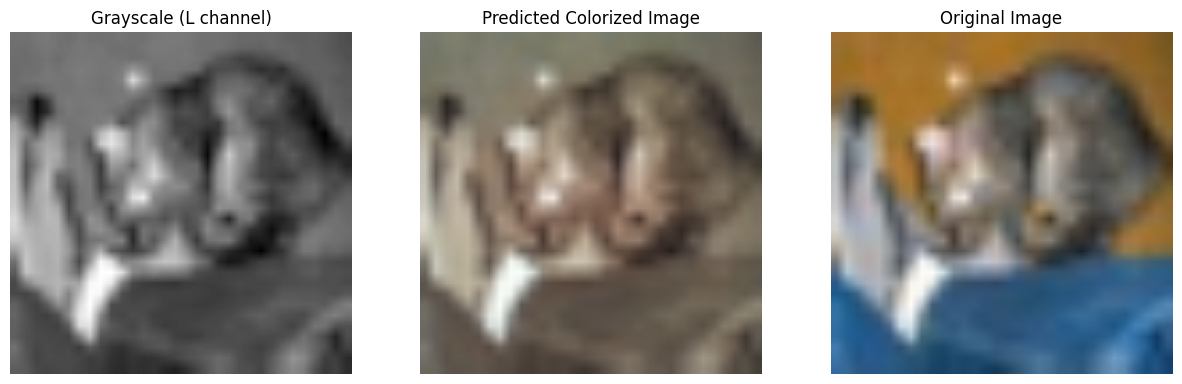

  0%|          | 0/1250 [00:01<?, ?it/s]

MSE: 0.0134
MAE: 0.0818
PSNR: 18.7320
SSIM: 0.9082
LPIPS: 0.1857


In [13]:

model = ColorizationModel().to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/Machine Learning Lab/Project/final_intnskip_cat.pth'))


lpips_model = lpips.LPIPS(net='alex').to(device)


batch_size = 8
_, test_loader = load_cifar10_data(batch_size)


evaluate_model(model, test_loader, lpips_model, device)
